In [1]:
import joblib

In [2]:
import os
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0,rpath)
from src.plots import Plot
from src.preprocessing import PreProcess
from db_connection.database import Database

In [4]:
kmeans = joblib.load('../models/kmeans_model.pkl')
kmeans

KMeans(n_clusters=3, random_state=42)

In [5]:
df = pd.read_csv('../data/cleaned_data_outliers.csv')
df['avg_tcp_retrans'] = df['tcp_dl_retrans._vol_(bytes)'] + df['tcp_ul_retrans._vol_(bytes)']
df['avg_rrt'] = df['avg_rtt_dl_(ms)'] + df['avg_rtt_dl_(ms)']
df['avg_bearer_tp'] = df['avg_bearer_tp_dl_(kbps)'] + df['avg_bearer_tp_ul_(kbps)']
df["social_media"] = df["social_media_dl_(bytes)"] + df['social_media_ul_(bytes)']
df["google"] = df["google_dl_(bytes)"] + df["google_ul_(bytes)"]
df['email'] = df["email_dl_(bytes)"] + df["email_ul_(bytes)"]
df['youtube'] = df["youtube_dl_(bytes)"] + df["youtube_ul_(bytes)"]
df['netflix'] = df["netflix_dl_(bytes)"] + df["netflix_ul_(bytes)"]
df["gaming"] = df["gaming_dl_(bytes)"] + df["gaming_ul_(bytes)"]
df['other'] = df["other_dl_(bytes)"]+df["other_ul_(bytes)"]
df['total_data'] = df['total_dl_(bytes)'] + df['total_ul_(bytes)']

In [6]:
column_name = 'msisdn/number'
value_to_match = 33663706799.0
mask = df[column_name] == value_to_match
df = df[~mask]

In [7]:
preprocess = PreProcess(df)

In [8]:
agg_data = df.groupby('msisdn/number').agg({'avg_tcp_retrans':sum,'avg_rrt':sum,'avg_bearer_tp':sum})
preprocess.replace_neg_inf_with_mean(agg_data)

,avg_tcp_retrans,avg_rrt,avg_bearer_tp
msisdn/number,,,
3.360100e+10,23.201031,7.657283,7.274480
3.360100e+10,23.201031,6.802395,7.803027
3.360100e+10,23.201031,7.613325,7.763021
3.360101e+10,16.921539,8.468213,9.102310
3.360101e+10,49.213729,15.573104,27.135851
...,...,...,...
3.379000e+10,20.285299,7.475339,15.166563
3.379000e+10,23.201031,7.052721,8.090709
3.197021e+12,23.201031,7.613325,16.089721


**Experience score to each user**

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(agg_data[['avg_tcp_retrans','avg_rrt','avg_bearer_tp']])

In [11]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(cluster_centers, columns=['avg_tcp_retrans','avg_rrt','avg_bearer_tp'])

In [12]:
print("Cluster Centers:")
print(centroid_df)

Cluster Centers:
   avg_tcp_retrans    avg_rrt  avg_bearer_tp
0        22.803067   7.940064      11.011754
1        49.151734  16.482872      24.187841
2       103.877151  35.805388      63.802692


In [13]:
from sklearn.metrics.pairwise import euclidean_distances

# Calculate Euclidean distances between each user and the centroids
distances = euclidean_distances(scaled_features, cluster_centers)

# Find the cluster index for the less engaged cluster (assuming Cluster 0 is less engaged)
less_engaged_cluster_index = 0

# Extract the distances for the less engaged cluster
engagement_scores = distances[:, less_engaged_cluster_index]

# Add the engagement scores to the DataFrame
agg_data['Experience_Score'] = engagement_scores


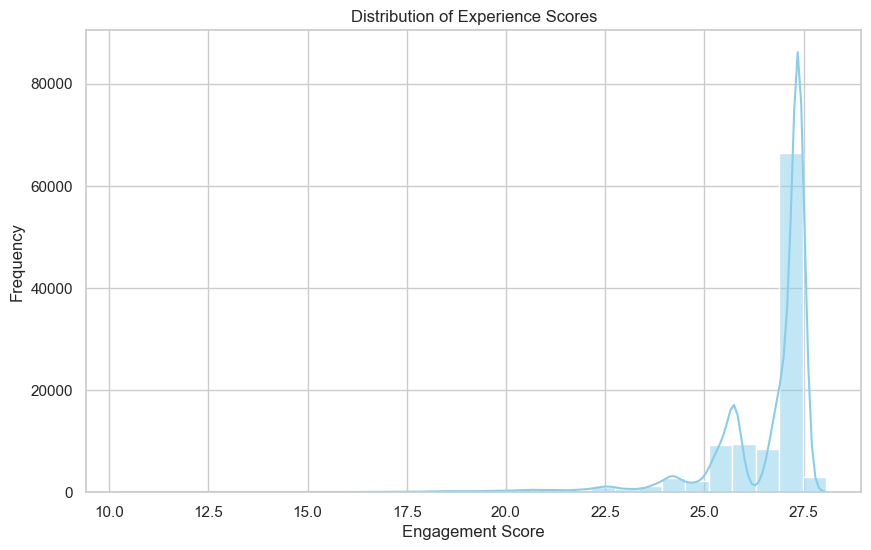

In [14]:
# Set the style for better visualization
sns.set(style="whitegrid")

# Create a histogram of engagement scores
plt.figure(figsize=(10, 6))
sns.histplot(agg_data['Experience_Score'], bins=30, kde=True, color='skyblue')

# Set plot labels and title
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.title('Distribution of Experience Scores')

# Display the plot
plt.show()


This is what we call left skewed, which suggests that there are fewer users with lower experience score, while a significant proportion of users has higher experience scores.

**Engagement score to each user**

In [15]:
user_engagement_kmeans = joblib.load('../models/user_engagement.pkl')

In [16]:
df = df.rename( columns={'bearer_id': 'sessions'})

In [17]:
data_aggregate = df.groupby('msisdn/number').agg({'sessions': 'count', 'dur._(ms)': 'sum', 'total_data': 'sum'})
data_aggregate.nlargest(5,'sessions')

,sessions,dur._(ms),total_data
msisdn/number,,,
3.362632e+10,18,231.977427,667.707948
3.361489e+10,17,222.446521,633.565683
3.362578e+10,17,233.413129,634.698734
3.365973e+10,16,198.016024,592.952528
3.367588e+10,15,188.665113,559.199968


In [18]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_aggregate[['sessions','dur._(ms)','total_data']])


In [19]:
cluster_centers = scaler.inverse_transform(user_engagement_kmeans.cluster_centers_)
centroid_df = pd.DataFrame(cluster_centers, columns=['sessions','dur._(ms)','total_data'])

In [20]:
from sklearn.metrics.pairwise import euclidean_distances

# Calculate Euclidean distances between each user and the centroids
distances = euclidean_distances(scaled_features, cluster_centers)

# Find the cluster index for the less engaged cluster (assuming Cluster 0 is less engaged)
less_engaged_cluster_index = 0

# Extract the distances for the less engaged cluster
engagement_scores = distances[:, less_engaged_cluster_index]

# Add the engagement scores to the DataFrame
data_aggregate['Engagement_Score'] = engagement_scores


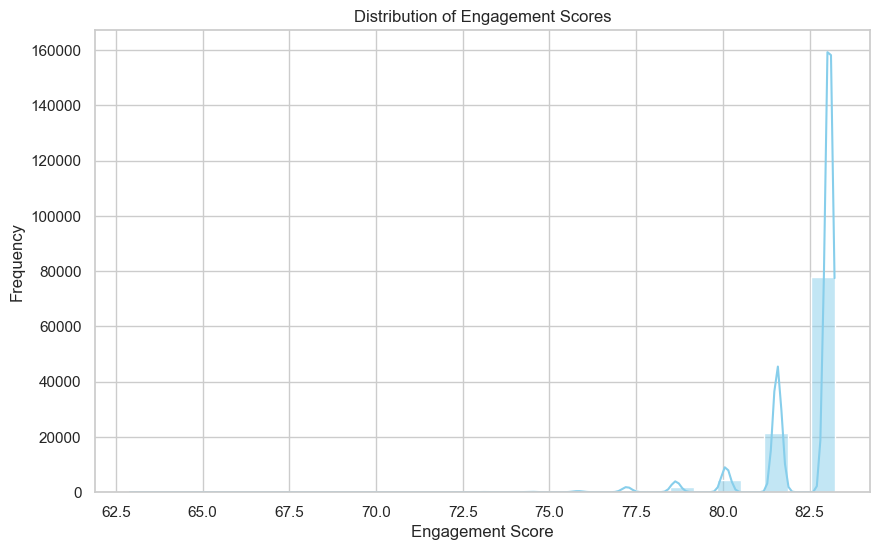

In [21]:
# Set the style for better visualization
sns.set(style="whitegrid")

# Create a histogram of engagement scores
plt.figure(figsize=(10, 6))
sns.histplot(data_aggregate['Engagement_Score'], bins=30, kde=True, color='skyblue')

# Set plot labels and title
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.title('Distribution of Engagement Scores')

# Display the plot
plt.show()

Top 10 on the engagement score

In [22]:
agg_data['Engagement_Score'] = data_aggregate['Engagement_Score'] 

In [23]:
agg_data['Satisfaction_Score'] = agg_data['Experience_Score'] + agg_data['Engagement_Score']

In [24]:
satified_customer = agg_data.nlargest(10,'Satisfaction_Score')

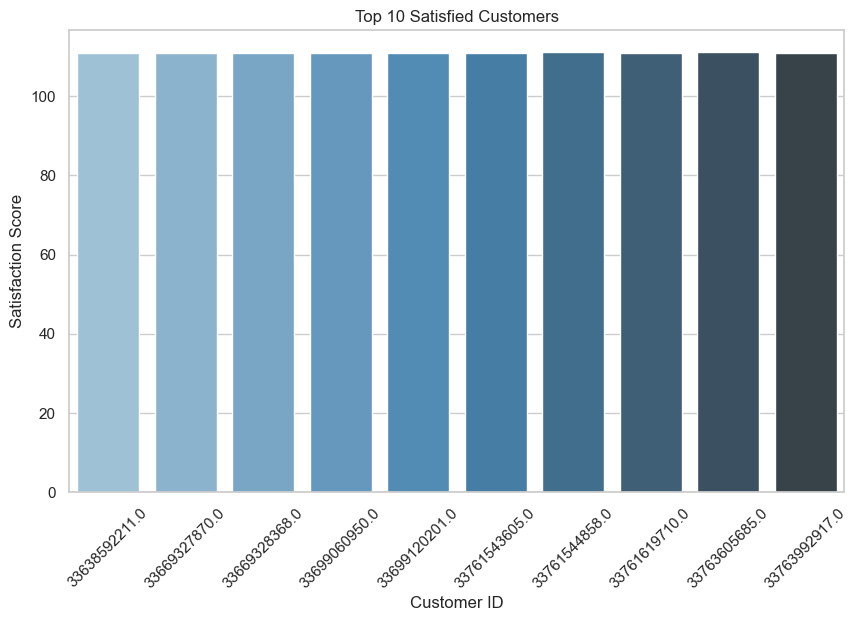

In [25]:
#Plot the top 10 satisfied customers
plt.figure(figsize=(10, 6))
sns.barplot(x=satified_customer.index, y="Satisfaction_Score", data=satified_customer, palette="Blues_d")
plt.title('Top 10 Satisfied Customers')
plt.xlabel('Customer ID')
plt.ylabel('Satisfaction Score')
plt.xticks(rotation=45)
plt.show()

In [27]:
agg_data

,avg_tcp_retrans,avg_rrt,avg_bearer_tp,Experience_Score,Engagement_Score,Satisfaction_Score
msisdn/number,,,,,,
3.360100e+10,23.201031,7.657283,7.274480,27.360778,83.034796,110.395574
3.360100e+10,23.201031,6.802395,7.803027,27.383015,83.086989,110.470004
3.360100e+10,23.201031,7.613325,7.763021,27.346866,83.041880,110.388746
3.360101e+10,16.921539,8.468213,9.102310,27.539819,83.098256,110.638075
3.360101e+10,49.213729,15.573104,27.135851,25.231993,81.589195,106.821188
...,...,...,...,...,...,...
3.379000e+10,20.285299,7.475339,15.166563,27.245494,83.114846,110.360340
3.379000e+10,23.201031,7.052721,8.090709,27.362055,83.051195,110.413250
3.197021e+12,23.201031,7.613325,16.089721,27.081881,83.032031,110.113913


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 0 0 ... 0 0 0]


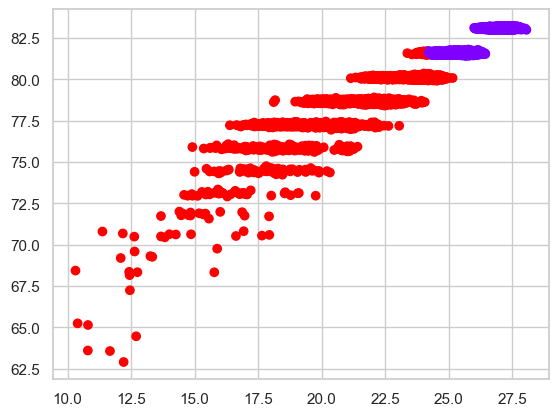

In [36]:
#Run k-means (k=2) on the engagement & the experience score
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Use fit_predict to cluster the dataset
predictions = kmeans.fit_predict(agg_data[['Experience_Score','Engagement_Score']])
print(predictions)

# Add the cluster predictions to the DataFrame
agg_data['Cluster'] = predictions

# Display cluster centers of each cluster
agg_data.groupby('Cluster').mean()

# Plot the histogram of various clusters
plt.scatter(agg_data['Experience_Score'], agg_data['Engagement_Score'], c=agg_data['Cluster'], cmap='rainbow')
plt.show()

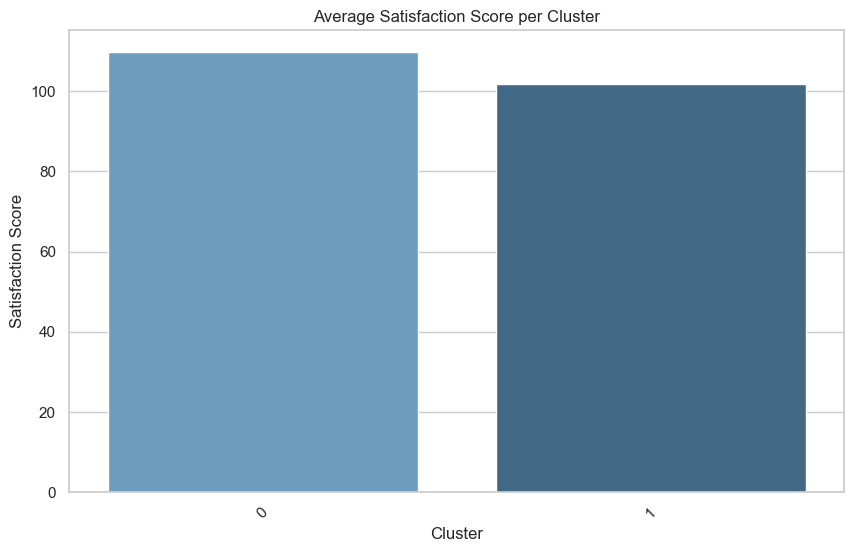

In [47]:
#Aggregate the average satisfaction & experience score per cluster
cluster_data = agg_data.groupby('Cluster').mean()
#Plot the average satisfaction & experience score per cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_data.index, y="Satisfaction_Score", data=cluster_data, palette="Blues_d")
plt.title('Average Satisfaction Score per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Satisfaction Score')
plt.xticks(rotation=45)
plt.show()